<a href="https://colab.research.google.com/github/chakma21/BTP/blob/main/graphNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Step 1: Upload file (CSV or Excel) ---
from google.colab import files
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import os
from itertools import combinations


print("📂 Please upload the CSV or Excel file with generalized keyword columns")
uploaded = files.upload()

# Detect uploaded filename
filename = list(uploaded.keys())[0]

# Function to load file based on extension
def load_file(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(file_path)
    elif ext in [".xlsx", ".xls"]:
        return pd.read_excel(file_path)
    else:
        raise ValueError("❌ Unsupported file format. Please upload CSV or Excel.")

# Load dataframe
df = load_file(filename)


📂 Please upload the CSV or Excel file with generalized keyword columns


Saving finalkeywordlist.xlsx to finalkeywordlist (1).xlsx


✅ Using keyword columns: keyword1, keyword2


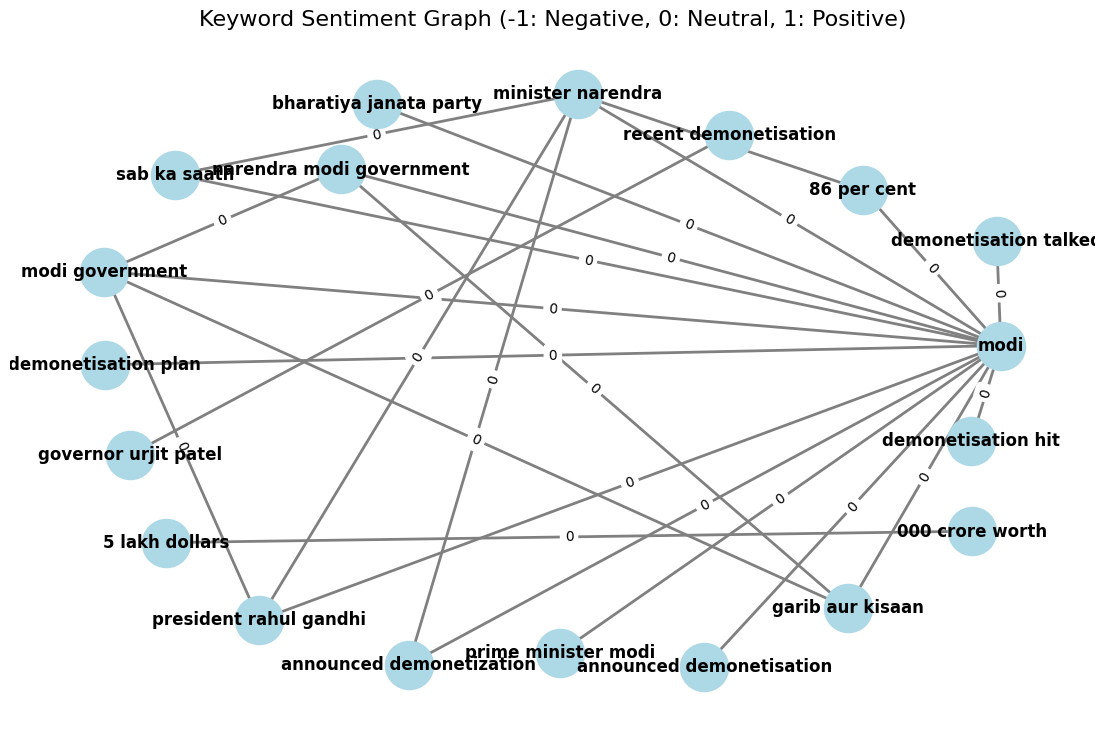

In [ ]:

# --- Step 2: Detect keyword columns ---
# Pick the generalized columns if present, otherwise fallback to original
keyword_cols = [col for col in df.columns if "_generalized" in col.lower()]
if len(keyword_cols) < 2:
    keyword_cols = ["keyword1", "keyword2"]

if len(keyword_cols) < 2:
    raise ValueError("❌ Could not find at least two keyword columns in the Excel file.")

print(f"✅ Using keyword columns: {keyword_cols[0]}, {keyword_cols[1]}")

# --- Step 3: Sentiment mapping ---
sentiment_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1,
    '1': 1,
    '0': 0,
    '-1': -1
}

# Collect all occurrences per keyword pair
pair_sentiment_counts = defaultdict(list)

# Loop through rows
for _, row in df.iterrows():
    # Get all keywords in lowercase without empty ones
    keywords = [str(row[col]).strip().lower() for col in keyword_cols if str(row[col]).strip()]
    sentiment = str(row['sentiment']).strip().lower()

    mapped_sentiment = sentiment_map.get(sentiment, 0)

    # Build ALL unique pairs from the row (combinations handles this)
    for k1, k2 in combinations(sorted(set(keywords)), 2):
        pair_sentiment_counts[(k1, k2)].append(mapped_sentiment)

# --- Step 4: Build the graph ---
G = nx.Graph()

for (k1, k2), sentiments in pair_sentiment_counts.items():
    # Get most common sentiment for this pair
    sentiment_counts = Counter(sentiments)
    most_common_sentiment = sentiment_counts.most_common(1)[0][0]
    G.add_edge(k1, k2, weight=most_common_sentiment)

# --- Step 5: Visualize ---
edge_colors = []
for u, v in G.edges():
    w = G[u][v]['weight']
    if w > 0:
        edge_colors.append('green')
    elif w < 0:
        edge_colors.append('red')
    else:
        edge_colors.append('gray')

plt.figure(figsize=(14, 9))
pos = nx.spring_layout(G, seed=42, k=0.8)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Keyword Sentiment Graph (-1: Negative, 0: Neutral, 1: Positive)", fontsize=16)
plt.axis('off')
plt.show()